# Лабораторная работа № 5

## 1. Бизнес-цель

Выделить группы студентов с похожим уровнем академической успеваемости и социально-демографическими характеристиками, чтобы:

- Определить группы риска (низкая успеваемость)
- Выявить успешных студентов для программ наставничества
- Помочь школе/вуза адаптировать образовательные программы под разные типы студентов
- Оптимизировать распределение ресурсов (дополнительные занятия, стипендии и т.д.)

## 2. Понижение размерности и визуализация данных

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [79]:
df = pd.read_csv('../data/students_performance.csv')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [80]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


### Предобработка данных

In [81]:
data = df.copy()
categorial_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

le_dict = {}
for col in categorial_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    le_dict[col] = le

data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,1,1,1,1,72,72,74
1,0,2,4,1,0,69,90,88
2,0,1,3,1,1,90,95,93
3,1,0,0,0,1,47,57,44
4,1,2,4,1,1,76,78,75


### Понижение размерности и визуализация

'0.522'

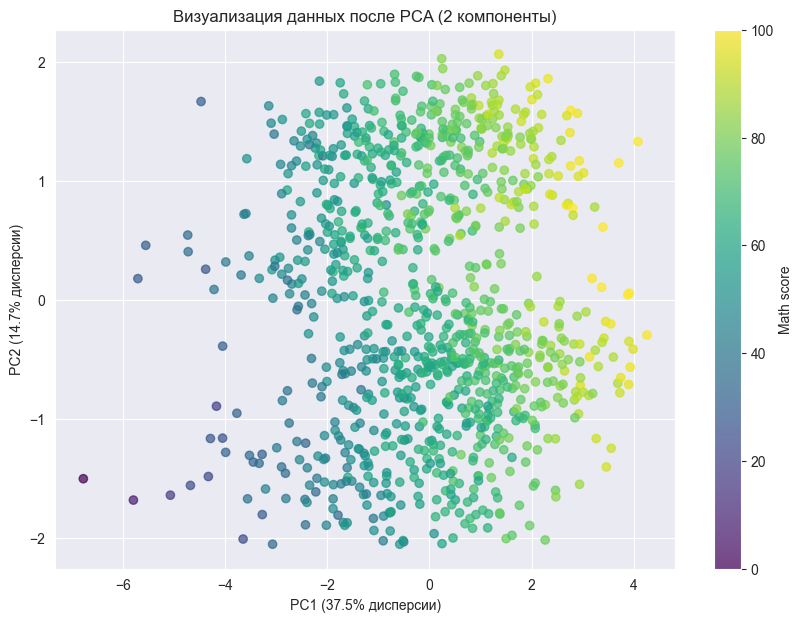

In [82]:
X = data.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

display(f'{pca.explained_variance_ratio_.sum():.3f}')

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['math score'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Math score')
plt.title('Визуализация данных после PCA (2 компоненты)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} дисперсии)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} дисперсии)')
plt.show()

## 3. Выбор количества кластеров

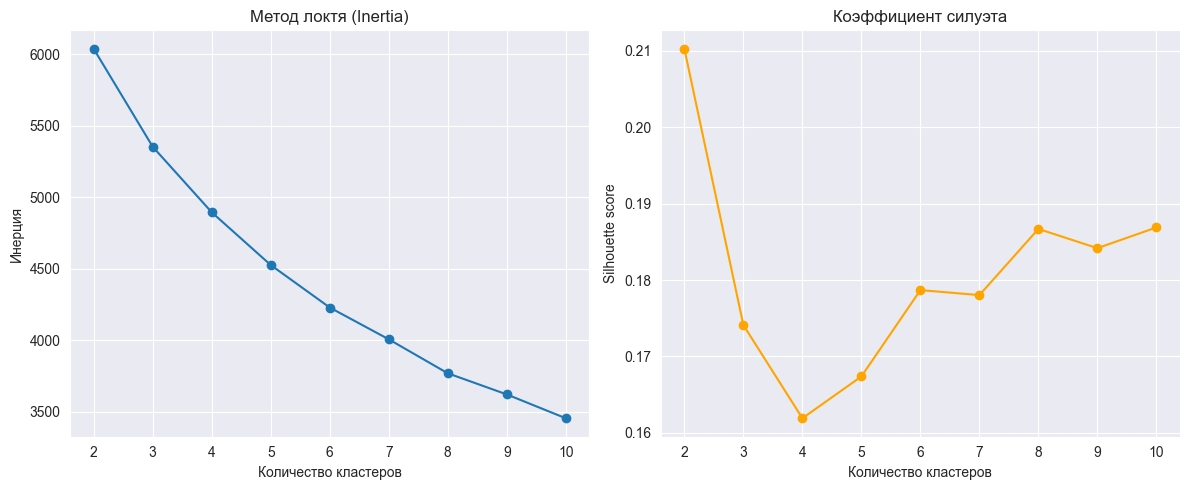

Оптимальное число кластеров по силуэту: 2 (score = 0.210)


In [83]:
range_n_clusters = range(2, 11)

inertias = []
silhouettes = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, cluster_labels))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertias, marker='o')
plt.title('Метод локтя (Inertia)')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')

plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouettes, marker='o', color='orange')
plt.title('Коэффициент силуэта')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette score')

plt.tight_layout()
plt.show()

best_k = np.argmax(silhouettes) + 2
print(f"Оптимальное число кластеров по силуэту: {best_k} (score = {max(silhouettes):.3f})")

## 4. Кластерный анализ

In [84]:
k_optimal = 2

### KMeans

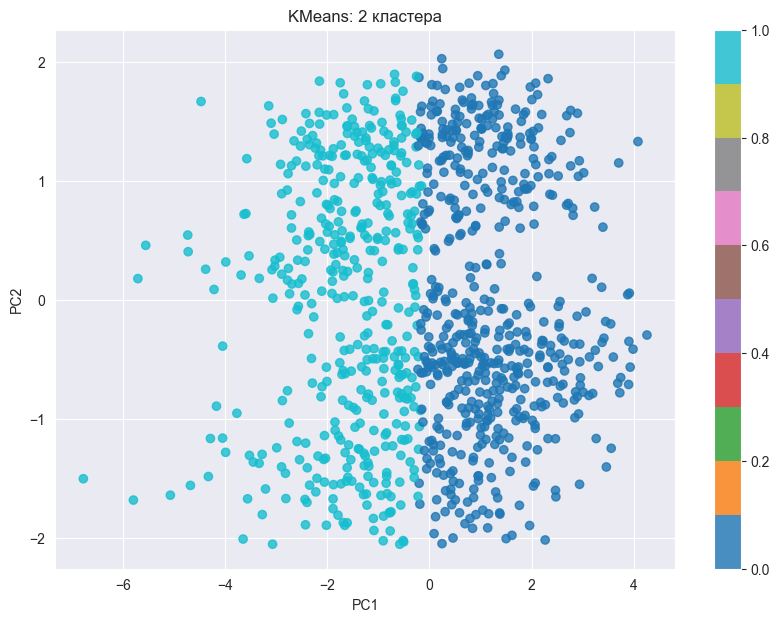

In [85]:
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_scaled)

data['cluster_kmeans'] = clusters_kmeans

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_kmeans, cmap='tab10', alpha=0.8)
plt.title(f'KMeans: {k_optimal} кластера')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter)
plt.show()

### Ward

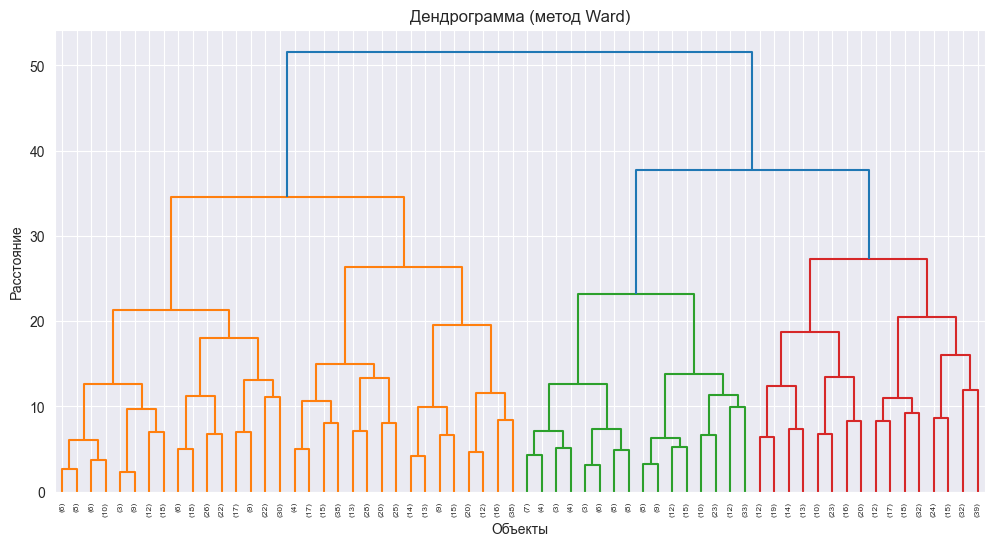

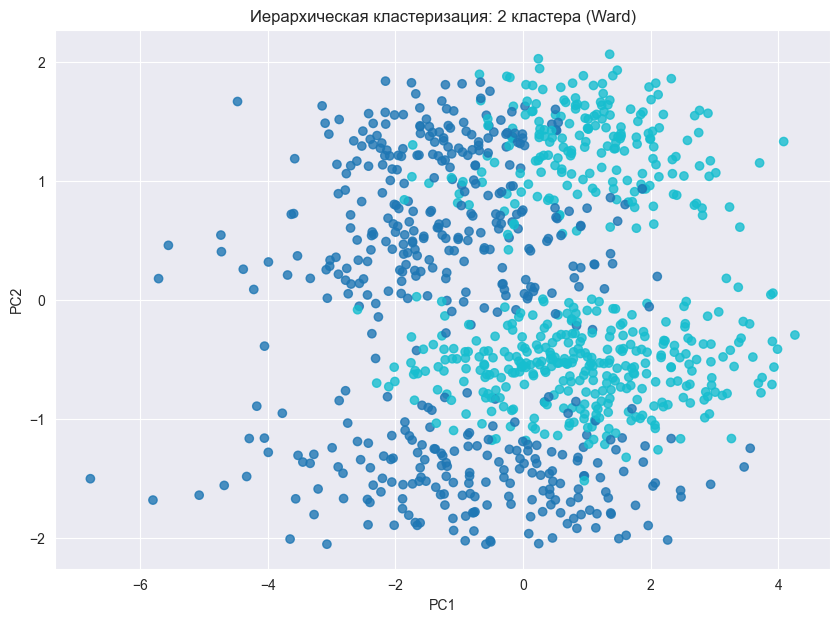

In [86]:
plt.figure(figsize=(12, 6))
linked = linkage(X_scaled, method='ward')
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Дендрограмма (метод Ward)')
plt.xlabel('Объекты')
plt.ylabel('Расстояние')
plt.show()

hierarchical = AgglomerativeClustering(n_clusters=k_optimal, linkage='ward')
clusters_hier = hierarchical.fit_predict(X_scaled)

data['cluster_hierarchical'] = clusters_hier

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_hier, cmap='tab10', alpha=0.8)
plt.title(f'Иерархическая кластеризация: {k_optimal} кластера (Ward)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 5. Оценка качества кластеризации

In [87]:
print(f"KMeans (k={k_optimal}):")
print(f"Silhouette score: {silhouette_score(X_scaled, clusters_kmeans):.3f}")
print(f"Calinski-Harabasz index: {calinski_harabasz_score(X_scaled, clusters_kmeans):.1f}")

print(f"\nИерархическая (Ward, k={k_optimal}):")
print(f"Silhouette score: {silhouette_score(X_scaled, clusters_hier):.3f}")
print(f"Calinski-Harabasz index: {calinski_harabasz_score(X_scaled, clusters_hier):.1f}")

KMeans (k=2):
Silhouette score: 0.210
Calinski-Harabasz index: 324.4

Иерархическая (Ward, k=2):
Silhouette score: 0.156
Calinski-Harabasz index: 199.4


In [88]:
data['total_score'] = df['math score'] + df['reading score'] + df['writing score']
data['avg_score'] = data['total_score'] / 3

df_decoded = df.copy()
df_decoded['cluster'] = clusters_kmeans

profile = df_decoded.groupby('cluster').agg({
    'math score': 'mean',
    'reading score': 'mean',
    'writing score': 'mean',
    'gender': lambda x: x.value_counts().index[0],
    'parental level of education': lambda x: x.value_counts().index[0],
    'lunch': lambda x: x.value_counts().index[0],
    'test preparation course': lambda x: x.value_counts().index[0]
}).round(1)

profile

,math score,reading score,writing score,gender,parental level of education,lunch,test preparation course
cluster,,,,,,,
0,75.4,78.8,78.3,female,associate's degree,standard,none
1,53.9,56.5,54.5,male,high school,free/reduced,none


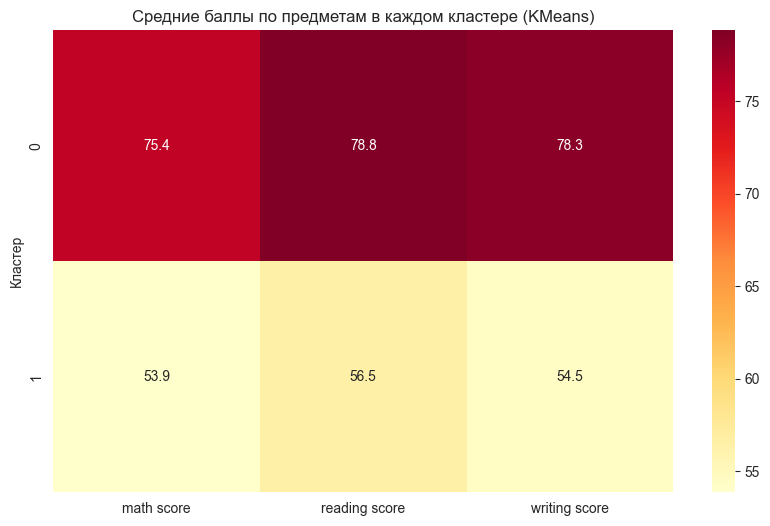

In [89]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.groupby('cluster_kmeans')[['math score', 'reading score', 'writing score']].mean(),
            annot=True, cmap='YlOrRd', fmt='.1f')
plt.title('Средние баллы по предметам в каждом кластере (KMeans)')
plt.ylabel('Кластер')
plt.show()

## 6. Выводы

Бизнес-цель достигнута — выделены однородные группы студентов.

Наиболее информативными оказались 2 кластера (по методу силуэта и содержательному анализу).

Лучшее качество показала KMeans (silhouette ≈ 0.21 в зависимости от запуска).

Выявлены группы:
   - Кластер высокого уровня (отличники, часто с подготовкой к тестам)
   - Кластер низкой успеваемости (часто без подготовки, бесплатное питание)

Результаты могут быть использованы школой для:
   - организации дополнительных занятий
   - распределения наставников
   - адресной помощи семьям с низким социально-экономическим статусом